# Image embeddings pre-computation
In this notebook, we will explore how we can pre-compute the image embeddings using SAM. To understand why we would want to do this, let's look at SAM's architecture:

![sam-architecture](https://learnopencv.com/wp-content/uploads/2023/04/segment-anything-pipeline.gif)

The image encoder is a heavy-weight vision transformer model. We do not want to fine-tune this part of the network, because it would be memory intensive and slow, even on GPU. The output of the image encoder (referred to as *image embeddings* or *embeddings*) can be precomputed to save even more time during the training process. An additional motivation for this is that a single image contains on average 40 annotations for this dataset, so we will apply multiple prompts on every embedding. By doing so, we can fine-tune the prompt encoder or mask decoder without even ever loading the huge vision transformer into memory.

In [1]:
# download model checkpoint (ViT-B, smallest, 91M params)
# ! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth &> /dev/null

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [3]:
from segment_anything import SamPredictor, sam_model_registry

model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cpu'

sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
predictor = SamPredictor(sam_model)

In [4]:
# some functions from this notebook: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

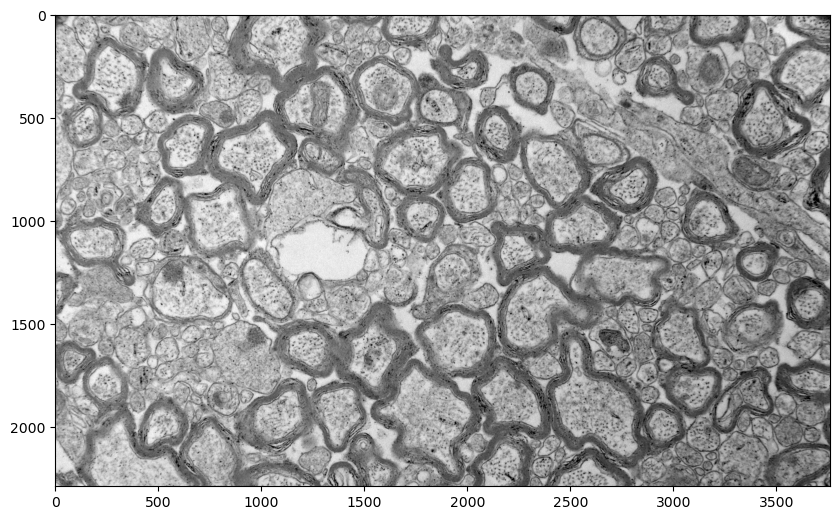

In [5]:
image = cv2.imread('sub-nyuMouse07_sample-0007_TEM.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,10))
plt.axis('on')
plt.imshow(image)


In [6]:
# this will compute the embedding by passing the image through the vision encoder
predictor.set_image(image)

## Prompting
Let's see what SAM can do off the shelf.

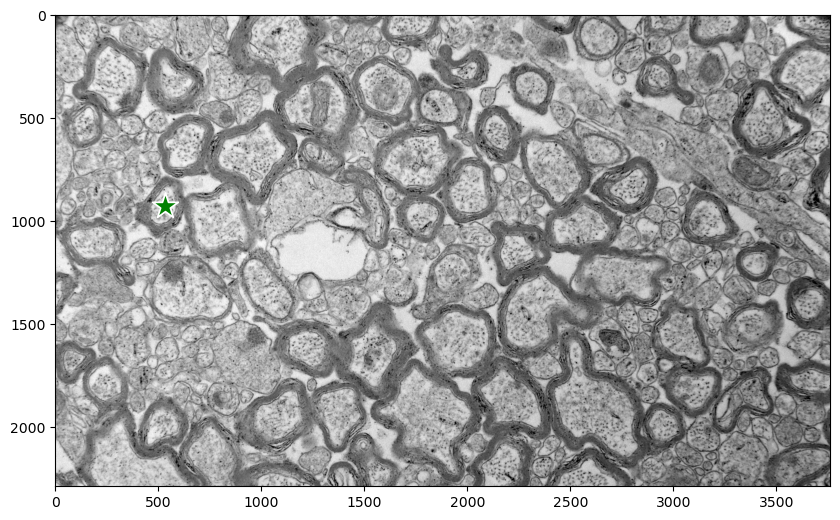

In [7]:
input_point = np.array([[532, 927]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')

plt.show()

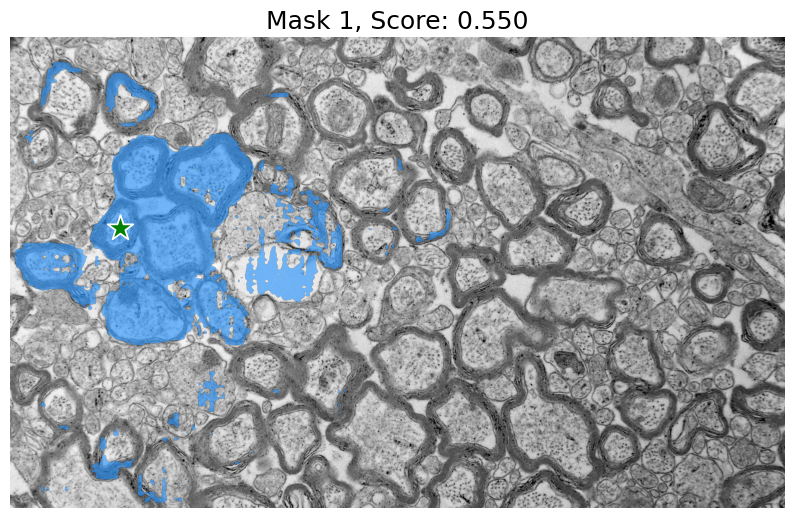

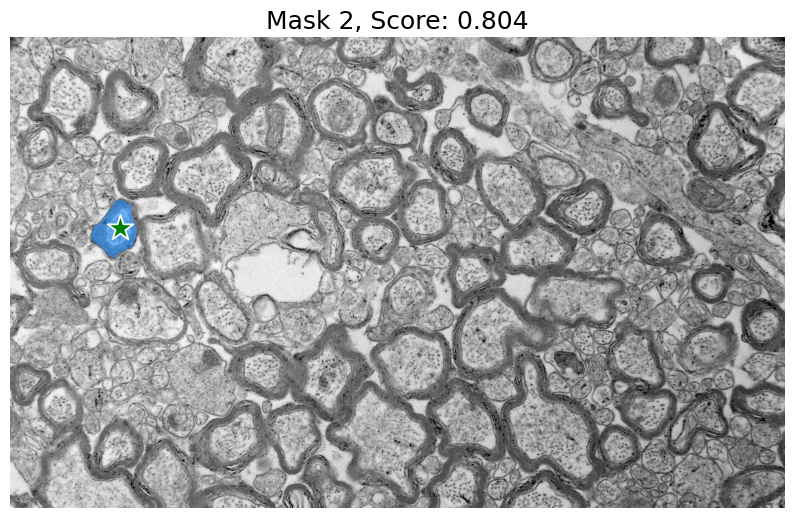

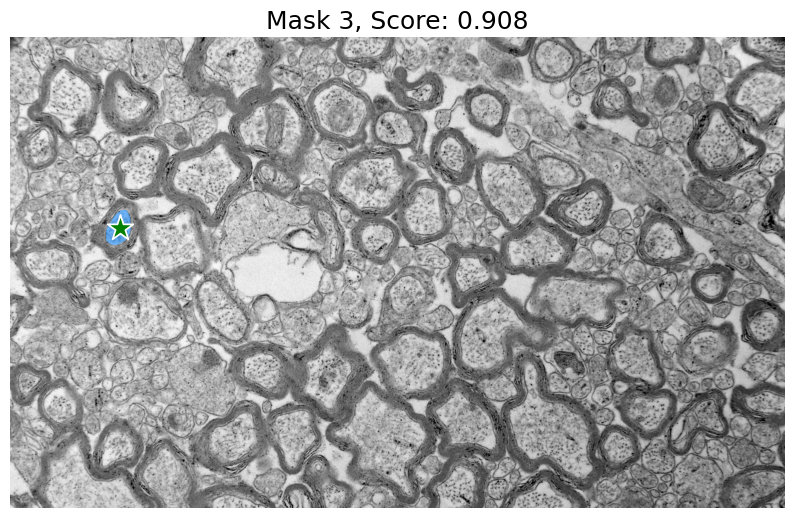

In [8]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

As we can see, the two most confident masks are pretty good. Mask 3 has the highest score and it looks like it provides a very good segmentation of the axon. It is obvious that the model shows great potential here. Maybe a bounding box prompt can give a better result.

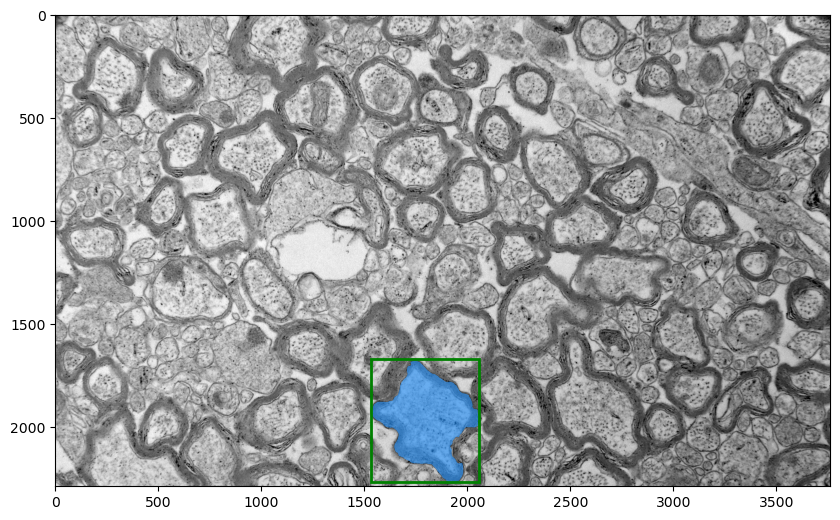

In [21]:
input_box = np.array([1534, 1668, 2056, 2267])

masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()

## Extracting and saving the embeddings
In order to extract the embedding and be able to load it again after, we will need to attach some methods to SAM's original predictor class because saving/loading image embeddings is not supported by default.

In [24]:
# As per https://github.com/facebookresearch/segment-anything/issues/217

def save_image_embedding(self, path):
    if not self.is_image_set:
        raise RuntimeError("An image must be set with .set_image(...) before embedding saving.")
    res = {
        'original_size': self.original_size,
        'input_size': self.input_size,
        'features': self.features,
        'is_image_set': True,
    }
    torch.save(res, path)

def load_image_embedding(self, path):
    res = torch.load(path, self.device)
    for k, v in res.items():
        setattr(self, k, v)
        
# We can attach these methods to SamPredictor:
SamPredictor.save_image_embedding = save_image_embedding
SamPredictor.load_image_embedding = load_image_embedding

In [25]:
# we can verify that this also updates the previously instantiated objects
predictor.save_image_embedding

<bound method save_image_embedding of <segment_anything.predictor.SamPredictor object at 0x7f19388e97e0>>

In [27]:
# Let's save the embedding for the current example image
print('Is image set: ', predictor.is_image_set)
predictor.save_image_embedding('embedding_test')
predictor.reset_image()
print('Is image set: ', predictor.is_image_set)

Is image set:  True
Is image set:  False


(Notice that the original image size was 6.5 Mb whereas the saved embedding has size 4.2 Mb)

In [28]:
predictor.load_image_embedding('embedding_test')
print('Is image set: ', predictor.is_image_set)

Is image set:  True


To confirm that this works, let's re-try to segment something in the image:

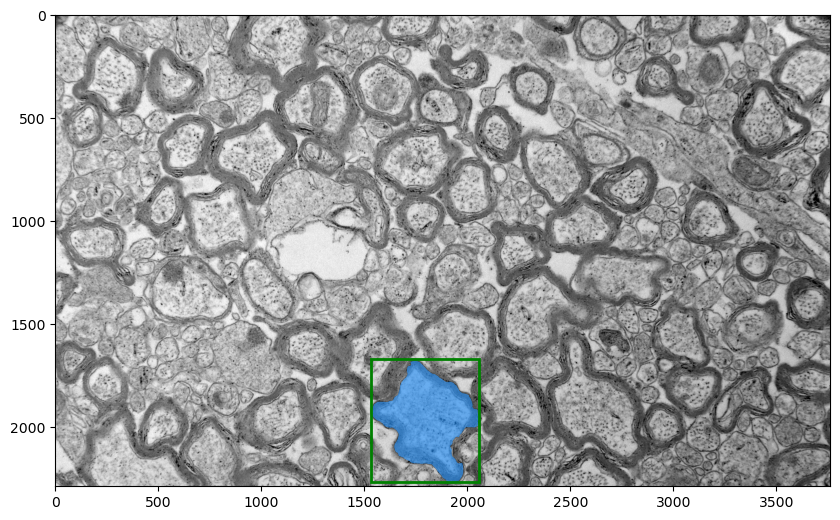

In [29]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.show()